In [3]:
# ライブラリのインポート
## データ加工・可視化系ライブラリ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='IPAexGothic')

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

In [4]:
# データのインポート
## 学習用データ 13列 11900行、Y列がある
train = pd.read_csv('train.csv')
## テスト用データ 12列 5100行、Y列がない
test = pd.read_csv('test.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11900 entries, 0 to 11899
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   file            11900 non-null  object
 1   index           11900 non-null  int64 
 2   age             11900 non-null  int64 
 3   workclass       11900 non-null  object
 4   fnlwgt          11900 non-null  int64 
 5   education       11900 non-null  object
 6   education-num   11900 non-null  int64 
 7   marital-status  11900 non-null  object
 8   occupation      11900 non-null  object
 9   relationship    11900 non-null  object
 10  race            11900 non-null  object
 11  sex             11900 non-null  object
 12  native-country  11900 non-null  object
 13  Y               11900 non-null  int64 
dtypes: int64(5), object(9)
memory usage: 1.3+ MB


In [5]:
# 説明変数列をtrain, testで結合
col_from = 'file'
col_to = 'native-country'

# 先頭列にファイル区別列を追加
train.insert(0, 'file', 'train')
test.insert(0, 'file', 'test')

all_data = pd.concat((train.loc[:,col_from:col_to],
                      test.loc[:,col_from:col_to]))

<Axes: ylabel='Frequency'>

findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

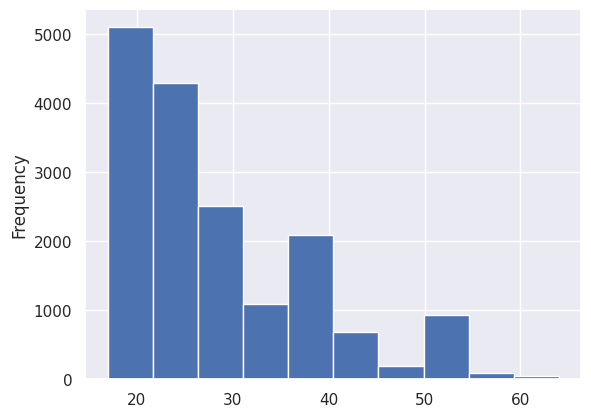

In [6]:
# # 列ごとのデータ俯瞰

# age
df = all_data

num = 'age'
df[num].plot.hist()

# 20代に偏っている

In [9]:
colums=list(train.columns)
print(colums)
df = train
df0= df[df['Y']==0]
df1= df[df['Y']==1]
bins = [-1,0,1,2]
s0 = pd.cut(df0['native-country'], bins).value_counts().sort_index()
s1 = pd.cut(df1['native-country'], bins).value_counts().sort_index()
dfx = pd.DataFrame({'Y':s0, 'not_Y':s1})
dfx = dfx.assign( **{'全体': lambda p: p.sum(axis=1)} )
display(dfx)
from matplotlib.font_manager import FontProperties

t = dfx.apply( lambda p: p/p[-1] , axis=1 )
display(t)
col = ["Y","not_Y"] 
t[col].plot.barh(stacked=True)
plt.legend(col)
plt.show()

['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Y']


TypeError: '<' not supported between instances of 'int' and 'str'

In [10]:
display(train.head())
display(test.head())

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,Private,132652,Some-college,10,Divorced,Adm-clerical,Own-child,White,Female,United-States,0
1,train,11968,29,Private,132652,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,United-States,0
2,train,10868,19,Private,132652,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,United-States,0
3,train,3394,17,Private,132652,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,United-States,0
4,train,15993,47,Private,132652,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,0


,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,Local-gov,132652,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
1,test,3625,23,Private,132652,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,United-States
2,test,3028,19,Private,132652,11th,7,Never-married,Handlers-cleaners,Own-child,White,Female,United-States
3,test,13814,30,State-gov,132652,HS-grad,9,Never-married,Protective-serv,Unmarried,Black,Female,United-States
4,test,15398,60,Private,132652,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States


In [11]:
colums=list(train.columns)
print(colums)
name_set =list(set(train.loc[:,colums[1]]))
print(len(name_set))
for i in range(len(name_set)):
    print(i,name_set[i])

['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Y']
11900
0 0
1 1
2 2
3 3
4 4
5 6
6 10
7 11
8 13
9 15
10 17
11 19
12 21
13 22
14 23
15 24
16 25
17 26
18 27
19 28
20 29
21 30
22 32
23 34
24 35
25 36
26 40
27 41
28 43
29 46
30 47
31 49
32 52
33 53
34 54
35 55
36 56
37 58
38 59
39 60
40 61
41 62
42 63
43 64
44 66
45 67
46 68
47 69
48 71
49 72
50 73
51 75
52 76
53 77
54 78
55 79
56 80
57 81
58 82
59 84
60 85
61 86
62 89
63 91
64 92
65 93
66 95
67 96
68 97
69 98
70 99
71 100
72 101
73 102
74 104
75 105
76 106
77 107
78 108
79 109
80 110
81 111
82 113
83 114
84 115
85 116
86 117
87 118
88 120
89 123
90 128
91 129
92 130
93 131
94 132
95 135
96 136
97 137
98 139
99 140
100 141
101 143
102 145
103 147
104 148
105 149
106 151
107 152
108 156
109 158
110 160
111 161
112 162
113 163
114 165
115 166
116 170
117 171
118 173
119 175
120 177
121 178
122 179
123 180
124 182
125 183
126 184
1

In [12]:
test_shape = test.shape
train_shape = train.shape

print(train_shape) 
print(test_shape)

(11900, 14)
(5100, 13)


In [13]:
display(train.describe())
display(test.describe())

,index,age,fnlwgt,education-num,Y
count,11900.000000,11900.000000,11900.000000,11900.000000,11900.000000
mean,8474.659076,27.958319,130706.714118,10.384370,0.256134
std,4927.916370,9.563625,14218.695201,2.209696,0.436515
min,0.000000,17.000000,24694.000000,3.000000,0.000000
25%,4181.750000,20.000000,132652.000000,9.000000,0.000000
50%,8453.500000,24.000000,132652.000000,10.000000,0.000000
75%,12761.250000,34.000000,132652.000000,13.000000,1.000000
max,16997.000000,64.000000,132652.000000,16.000000,1.000000


,index,age,fnlwgt,education-num
count,5100.000000,5100.000000,5100.000000,5100.000000
mean,8557.462157,27.905686,131078.077647,10.409216
std,4859.924357,9.366789,12808.318785,2.247178
min,5.000000,17.000000,24694.000000,3.000000
25%,4428.750000,21.000000,132652.000000,9.000000
50%,8606.500000,24.000000,132652.000000,10.000000
75%,12726.500000,34.000000,132652.000000,13.000000
max,16999.000000,64.000000,132652.000000,16.000000


In [14]:
def kesson_table(df): 
        null_val = df.isnull().sum()
        percent = 100 * df.isnull().sum()/len(df)
        kesson_table = pd.concat([null_val, percent], axis=1)
        kesson_table_ren_columns = kesson_table.rename(
        columns = {0 : '欠損数', 1 : '%'})
        return kesson_table_ren_columns
 
display(kesson_table(train))
display(kesson_table(test))

,欠損数,%
file,0,0.0
index,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0


,欠損数,%
file,0,0.0
index,0,0.0
age,0,0.0
workclass,0,0.0
fnlwgt,0,0.0
education,0,0.0
education-num,0,0.0
marital-status,0,0.0
occupation,0,0.0
relationship,0,0.0


In [228]:
display(train.head())
colums=list(train.columns)
print(colums)
name_set =list(set(train.loc[:,colums[3]]))#wokclass
for i in range(len(name_set)):
    train[colums[3]][train[colums[3]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[5]]))#education
for i in range(len(name_set)):
    train[colums[5]][train[colums[5]] == name_set[i]] = i
    

name_set =list(set(train.loc[:,colums[7]]))#material_status
for i in range(len(name_set)):
    train[colums[7]][train[colums[7]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[8]]))#occupation
for i in range(len(name_set)):
    train[colums[8]][train[colums[8]] == name_set[i]] = i
name_set =list(set(train.loc[:,colums[9]]))#relationship
for i in range(len(name_set)):
    train[colums[9]][train[colums[9]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[10]]))#race
for i in range(len(name_set)):
    train[colums[10]][train[colums[10]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[11]]))#sex
for i in range(len(name_set)):
    train[colums[11]][train[colums[11]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[12]]))#native_country
for i in range(len(name_set)):
    train[colums[12]][train[colums[12]] == name_set[i]] = i

 
train.head(10)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,10,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,9,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,9,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,10,2,12,5,2,1,1,0


['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Y']


/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3981032096.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[colums[3]][train[colums[3]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3981032096.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[colums[5]][train[colums[5]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3981032096.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0
5,train,12706,23,5,132652,7,11,0,12,1,2,1,1,0
6,train,7809,44,6,132652,7,11,0,8,2,2,1,1,0
7,train,12889,19,5,132652,12,11,2,11,5,1,1,1,0
8,train,13121,41,5,132652,8,14,0,11,0,2,0,1,0
9,train,15731,31,5,132652,11,13,2,11,5,2,1,1,1


In [227]:
display(test.head())
colums=list(test.columns)
print(colums)
name_set =list(set(test.loc[:,colums[3]]))#wokclass
for i in range(len(name_set)):
    test[colums[3]][test[colums[3]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[5]]))#education
for i in range(len(name_set)):
    test[colums[5]][test[colums[5]] == name_set[i]] = i   

name_set =list(set(test.loc[:,colums[7]]))#material_status
for i in range(len(name_set)):
    test[colums[7]][test[colums[7]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[8]]))#occupation
for i in range(len(name_set)):
    test[colums[8]][test[colums[8]] == name_set[i]] = i
name_set =list(set(test.loc[:,colums[9]]))#relationship
for i in range(len(name_set)):
    test[colums[9]][test[colums[9]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[10]]))#race
for i in range(len(name_set)):
    test[colums[10]][test[colums[10]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[11]]))#sex
for i in range(len(name_set)):
    test[colums[11]][test[colums[11]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[12]]))#native_country
for i in range(len(name_set)):
    test[colums[12]][test[colums[12]] == name_set[i]] = i

 
test.head(10)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1
1,test,3625,23,5,132652,6,10,2,0,5,2,1,1
2,test,3028,19,5,132652,8,7,0,3,1,2,0,1
3,test,13814,30,6,132652,11,9,0,8,2,1,0,1
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1


['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3397405822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[colums[3]][test[colums[3]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3397405822.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[colums[5]][test[colums[5]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3397405822.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1
1,test,3625,23,5,132652,6,11,2,0,5,2,1,1
2,test,3028,19,5,132652,8,11,0,3,1,2,0,1
3,test,13814,30,6,132652,11,11,0,8,2,1,0,1
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1
5,test,13244,19,5,132652,11,11,0,0,1,2,1,1
6,test,2516,30,5,132652,11,11,0,6,0,2,1,1
7,test,3008,19,5,132652,6,11,0,3,1,2,1,1
8,test,2619,17,3,132652,10,13,2,6,5,2,1,1
9,test,2525,28,5,132652,11,11,2,4,3,2,0,1


In [341]:
# scikit-learnのインポートをします
from sklearn import tree

In [342]:
# 「train」の目的変数と説明変数の値を取得
target = train["Y"].values
features_two = train[["age", "sex", "education","workclass", "education-num","marital-status","relationship","race","native-country"]].values
 
# 決定木の作成とアーギュメントの設定
max_depth = 20
min_samples_split = 2
my_tree_two = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split = min_samples_split, random_state = 1)
result = my_tree_two
my_tree_two = my_tree_two.fit(features_two, target) 
 
# 「test」の説明変数の値を取得
test_features = test[["age", "sex", "education","workclass", "education-num","marital-status","relationship","race","native-country"]].values
 
# 「test」の説明変数を使って「my_tree_one」のモデルで予測
my_prediction = my_tree_two.predict(test_features)
result.score(features_two,target)

0.8710924369747899

In [217]:
# 予測データのサイズを確認
my_prediction.shape

(5100,)

In [218]:
#予測データの中身を確認
print(my_prediction)

[1 0 0 ... 0 0 0]


In [343]:
# PassengerIdを取得
PassengerId = np.array(test["index"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(my_prediction, PassengerId)
display(my_solution.head())
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("my_tree_one.csv",header=False)

,0
3873,1
3625,0
3028,0
13814,0
15398,1


,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0


['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Y']
[-1, 0, 1, 2, 3, 4, 5, 6]


,Y,not_Y,全体
"(-1, 0]",105,59,164
"(0, 1]",99,138,237
"(1, 2]",471,56,527
"(2, 3]",552,302,854
"(3, 4]",406,177,583
"(4, 5]",7010,2227,9237
"(5, 6]",209,89,298


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

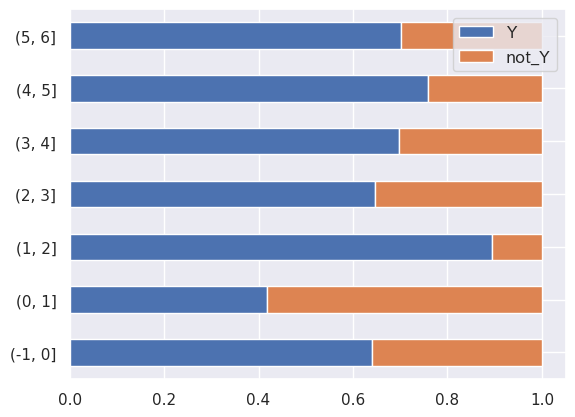

In [238]:
colums=list(train.columns)
display(train.head())
#display(train.describe())

print(colums)
df = train
df0= df[df['Y']==0]
df1= df[df['Y']==1]
bins = list(range(-1,7,1))
print(bins)
s0 = pd.cut(df0['workclass'], bins).value_counts().sort_index()
s1 = pd.cut(df1['workclass'], bins).value_counts().sort_index()
dfx = pd.DataFrame({'Y':s0, 'not_Y':s1})
dfx = dfx.assign( **{'全体': lambda p: p.sum(axis=1)} )
display(dfx)
from matplotlib.font_manager import FontProperties
fp= FontProperties(fname='ipaexg.ttf', size=12);
t = dfx.apply( lambda p: p/p[-1] , axis=1 )
#display(t)
col = ["Y","not_Y"] 
t[col].plot.barh(stacked=True)
plt.legend(col,prop=fp)
plt.show()

In [233]:
display(train.head())
colums=list(train.columns)
print(colums)
name_set =list(set(train.loc[:,colums[3]]))#wokclass
for i in range(len(name_set)):
    train[colums[3]][train[colums[3]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[5]]))#education
for i in range(len(name_set)):
    train[colums[5]][train[colums[5]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[6]]))#material_status
for i in range(len(name_set)):
    train[colums[6]][train[colums[6]] == 9] = 11
    train[colums[6]][train[colums[6]] == 10] = 11
    train[colums[6]][train[colums[6]] == 4] = 10
    train[colums[6]][train[colums[6]] == 5] = 10
    train[colums[6]][train[colums[6]] == 6] = 10
    train[colums[6]][train[colums[6]] == 7] = 10
    train[colums[6]][train[colums[6]] == 8] = 9
    train[colums[6]][train[colums[6]] == 3] = 9
    train[colums[6]][train[colums[6]] == 16] = 15
    
name_set =list(set(train.loc[:,colums[7]]))#material_status
for i in range(len(name_set)):
    train[colums[7]][train[colums[7]] != 2] = 0
    
name_set =list(set(train.loc[:,colums[8]]))#occupation
for i in range(len(name_set)):
    train[colums[8]][train[colums[8]] == name_set[i]] = i
name_set =list(set(train.loc[:,colums[9]]))#relationship
for i in range(len(name_set)):
    train[colums[9]][train[colums[9]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[10]]))#race
for i in range(len(name_set)):
    train[colums[10]][train[colums[10]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[11]]))#sex
for i in range(len(name_set)):
    train[colums[11]][train[colums[11]] == name_set[i]] = i
    
name_set =list(set(train.loc[:,colums[12]]))#native_country
for i in range(len(name_set)):
    train[colums[12]][train[colums[12]] == name_set[i]] = i

 
train.head(10)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0


['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'Y']


/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/783772620.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[colums[3]][train[colums[3]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/783772620.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[colums[5]][train[colums[5]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/783772620.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0
5,train,12706,23,5,132652,7,11,0,12,1,2,1,1,0
6,train,7809,44,6,132652,7,11,0,8,2,2,1,1,0
7,train,12889,19,5,132652,12,11,2,11,5,1,1,1,0
8,train,13121,41,5,132652,8,14,0,11,0,2,0,1,0
9,train,15731,31,5,132652,11,13,2,11,5,2,1,1,1


In [232]:
display(test.head())
colums=list(test.columns)
print(colums)
name_set =list(set(test.loc[:,colums[3]]))#wokclass
for i in range(len(name_set)):
    test[colums[3]][test[colums[3]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[5]]))#education
for i in range(len(name_set)):
    test[colums[5]][test[colums[5]] == name_set[i]] = i   

name_set =list(set(test.loc[:,colums[6]]))#material_status
for i in range(len(name_set)):
    test[colums[6]][test[colums[6]] == 9] = 11
    test[colums[6]][test[colums[6]] == 10] = 11
    test[colums[6]][test[colums[6]] == 4] = 10
    test[colums[6]][test[colums[6]] == 5] = 10
    test[colums[6]][test[colums[6]] == 6] = 10
    test[colums[6]][test[colums[6]] == 7] = 10
    test[colums[6]][test[colums[6]] == 8] = 9
    test[colums[6]][test[colums[6]] == 3] = 9
    test[colums[6]][test[colums[6]] == 16] = 15

name_set =list(set(test.loc[:,colums[7]]))#material_status
for i in range(len(name_set)):
    test[colums[7]][test[colums[7]] != 2] = 0
    
name_set =list(set(test.loc[:,colums[8]]))#occupation
for i in range(len(name_set)):
    test[colums[8]][test[colums[8]] == name_set[i]] = i
name_set =list(set(test.loc[:,colums[9]]))#relationship
for i in range(len(name_set)):
    test[colums[9]][test[colums[9]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[10]]))#race
for i in range(len(name_set)):
    test[colums[10]][test[colums[10]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[11]]))#sex
for i in range(len(name_set)):
    test[colums[11]][test[colums[11]] == name_set[i]] = i
    
name_set =list(set(test.loc[:,colums[12]]))#native_country
for i in range(len(name_set)):
    test[colums[12]][test[colums[12]] == name_set[i]] = i

 
test.head(10)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1
1,test,3625,23,5,132652,6,11,2,0,5,2,1,1
2,test,3028,19,5,132652,8,11,0,3,1,2,0,1
3,test,13814,30,6,132652,11,11,0,8,2,1,0,1
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1


['file', 'index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/2983157629.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[colums[3]][test[colums[3]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/2983157629.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[colums[5]][test[colums[5]] == name_set[i]] = i
/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/2983157629.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1
1,test,3625,23,5,132652,6,11,2,0,5,2,1,1
2,test,3028,19,5,132652,8,11,0,3,1,2,0,1
3,test,13814,30,6,132652,11,11,0,8,2,1,0,1
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1
5,test,13244,19,5,132652,11,11,0,0,1,2,1,1
6,test,2516,30,5,132652,11,11,0,6,0,2,1,1
7,test,3008,19,5,132652,6,11,0,3,1,2,1,1
8,test,2619,17,3,132652,10,13,2,6,5,2,1,1
9,test,2525,28,5,132652,11,11,2,4,3,2,0,1


In [382]:
train.dtypes

file              object
index              int64
age                int64
workclass          int64
fnlwgt             int64
education          int64
education-num      int64
marital-status     int64
occupation         int64
relationship       int64
race               int64
sex                int64
native-country     int64
Y                  int64
dtype: object

In [391]:
train.corr().style.background_gradient(axis=None)
#train["relationship"] = train["relationship"].astype(int)


/var/folders/42/922wnzy13c1bxs6j8mf7gwq00000gn/T/ipykernel_71848/3097137109.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr().style.background_gradient(axis=None)


,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
index,1.000000,0.003882,-0.005358,-0.001147,-0.006131,-0.013057,0.003436,0.001045,0.000646,-0.006180,0.002923,-0.006607,-0.003843
age,0.003882,1.000000,-0.108276,-0.016148,0.028354,0.235420,0.178708,0.068267,0.150734,0.039474,0.091882,-0.007715,0.268026
workclass,-0.005358,-0.108276,1.000000,-0.044768,0.002297,-0.026904,-0.080568,-0.004154,-0.070545,-0.015602,-0.082771,-0.005260,-0.059007
fnlwgt,-0.001147,-0.016148,-0.044768,1.000000,-0.015492,-0.048890,0.017428,-0.017923,0.032513,-0.006015,0.049985,0.008225,0.006812
education,-0.006131,0.028354,0.002297,-0.015492,1.000000,-0.014733,0.013349,0.001339,0.006415,-0.007505,-0.006746,0.042039,-0.018130
education-num,-0.013057,0.235420,-0.026904,-0.048890,-0.014733,1.000000,0.108443,-0.075564,0.046974,-0.028818,0.071645,0.026344,0.313058
marital-status,0.003436,0.178708,-0.080568,0.017428,0.013349,0.108443,1.000000,0.142500,0.899604,0.043319,0.495521,0.001931,0.510644
occupation,0.001045,0.068267,-0.004154,-0.017923,0.001339,-0.075564,0.142500,1.000000,0.141174,0.029132,0.211219,0.010935,0.033511
relationship,0.000646,0.150734,-0.070545,0.032513,0.006415,0.046974,0.899604,0.141174,1.000000,0.040542,0.515750,-0.004552,0.460121
race,-0.006180,0.039474,-0.015602,-0.006015,-0.007505,-0.028818,0.043319,0.029132,0.040542,1.000000,-0.000725,-0.045127,0.006903


In [383]:
def fit(classifier, parameters):
    gscv = GridSearchCV(classifier, parameters, cv=5)
    gscv.fit(X, y)

    print('Grid Search Best parameters:', gscv.best_params_)
    print('Grid Search Best validation score:', gscv.best_score_)
    print('Grid Search Best training score:', gscv.best_estimator_.score(X, y))

    predictions = gscv.best_estimator_.predict(X_test)

    X_pred = gscv.best_estimator_.predict(X)
    print('\n', classification_report(y, X_pred))

    return gscv

In [384]:
test_Y = pd.read_csv('my_submission.csv',header=None)
test_Y = test_Y.rename(columns={0: 'index',1:"Y"}, )
test_t= test
test_t['Y'] = test_Y["Y"]
train_t = pd.concat([train, test_t], axis=0)
display(train.shape)
display(test.shape)
display(train_t.shape)
display(train_t.head())

(11900, 14)

(5100, 14)

(17000, 14)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0


In [388]:
features = ["age", "workclass","education", "education-num","marital-status","occupation","relationship","race","native-country", "sex"]
y = train["Y"].astype('int')
tmp_sr = test['index']
X = train[features]
X_test = test[features]

In [393]:
%%time
parameters = [{'max_depth': np.arange(4, 20, 1),'n_estimators': np.arange(60, 141, 20), 'criterion': ['gini', 'entropy']}]
rf_gscv = fit(RandomForestClassifier(), parameters)

Grid Search Best parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 80}
Grid Search Best validation score: 0.8410084033613445
Grid Search Best training score: 0.8498319327731092

               precision    recall  f1-score   support

           0       0.88      0.92      0.90      8852
           1       0.74      0.64      0.69      3048

    accuracy                           0.85     11900
   macro avg       0.81      0.78      0.79     11900
weighted avg       0.85      0.85      0.85     11900

CPU times: user 5min 17s, sys: 1.19 s, total: 5min 18s
Wall time: 5min 19s


In [394]:
predictions = rf_gscv.best_estimator_.predict(X_test)
output = pd.DataFrame({'index': tmp_sr, 'Y': predictions})
output.to_csv('my_submission_0221v1.csv', header=False,index= False)

In [336]:
X = train.values[:,1:13]  
y=y.astype('int')
y = train.values[:,13] 
y=y.astype('int')
features = ["index","age", "workclass","fnlwgt","education", "education-num","marital-status","occupation","relationship","race","native-country","sex"]
X_test = test[features]

In [322]:
display(X.shape)
display(y.shape)

(11900, 12)

(11900,)

In [331]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate


# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 8)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

mean_score =  0.8360504201680671
mean_std =  0.0073877925559915165


In [332]:
mask= select.get_support()

# 項目のリスト
list_col = list(df.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

# シェイプの確認
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 index = False
No2 age = True
No3 workclass = True
No4 fnlwgt = False
No5 education = False
No6 education-num = True
No7 marital-status = True
No8 occupation = True
No9 relationship = True
No10 race = False
No11 sex = True
No12 native-country = True


IndexError: index 12 is out of bounds for axis 0 with size 12

In [335]:
PassengerId=test['index']
predictions = pipeline.predict(X_test)
submission = pd.DataFrame({"index": PassengerId, "Y": predictions.astype(np.int32)})
submission.to_csv("my_submission_0219v2.csv", header=False,index=False)

/Users/takumu/VScode/.venv/lib/python3.9/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


In [273]:
test_Y = pd.read_csv('my_submission.csv',header=None)
test_Y = test_Y.rename(columns={0: 'index',1:"Y"}, )

In [275]:
test_t= test
display(test_t.head())
display(test_Y.head())
display(train.head())

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1
1,test,3625,23,5,132652,6,11,2,0,5,2,1,1
2,test,3028,19,5,132652,8,11,0,3,1,2,0,1
3,test,13814,30,6,132652,11,11,0,8,2,1,0,1
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1


,index,Y
0,3873,1
1,3625,0
2,3028,0
3,13814,0
4,15398,1


,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0


In [276]:
test_t['Y'] = test_Y["Y"]

In [277]:
display(test_t.head())

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,test,3873,17,4,132652,7,14,2,2,5,2,1,1,1
1,test,3625,23,5,132652,6,11,2,0,5,2,1,1,0
2,test,3028,19,5,132652,8,11,0,3,1,2,0,1,0
3,test,13814,30,6,132652,11,11,0,8,2,1,0,1,0
4,test,15398,60,5,132652,10,13,2,2,5,2,1,1,1


In [282]:
train_t = pd.concat([train, test_t], axis=0)
display(train.shape)
display(test.shape)
display(train_t.shape)
display(train_t.head())

(11900, 14)

(5100, 14)

(17000, 14)

,file,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,train,322,21,5,132652,7,11,0,5,1,2,0,1,0
1,train,11968,29,5,132652,12,11,0,5,0,2,0,1,0
2,train,10868,19,5,132652,11,13,0,2,0,2,0,1,0
3,train,3394,17,5,132652,12,11,0,12,1,2,1,1,0
4,train,15993,47,5,132652,7,11,2,12,5,2,1,1,0
